#Introduction
This notebook will contain the CA to simulate stock prices based on agents. It will use the model described in [1].

# The model

## Traders
The traders have three states
* Buy = 1
* Sell = -1
* Inactive = 0

## The grid
We use a 2D grid with 512x128 cells. We initialize the grid at random with a small percentage of active traders. We use the von Neumann neighbours (up,down,left, right)

## Transition
* $p_h$ : probability that an active trader can turn one of its neighbours, i.e. $\sigma_i(t) = 0 \rightarrow \sigma_i(t+1) = \pm 1$
* $p_d$ : probability that an active trader diffuses and becomes inactive $\sigma_i(t) = 1 \rightarrow \sigma_i(t+1) = 0$
* $p_e$ : the probability that an non-active cell decides to enter the market $\sigma_i(t) = 0 \rightarrow \sigma_i(t+1) = 1$

## local probability rules
probabilistic rule : 
* $\sigma_i(t+1) = 1$ with probability $p_i^k$ 
* $\sigma_i(t+1)= -1$ with probability $(1-p_i^k)$ 

where $p_i^k$ is

$$p_i^k(t) = \frac{1}{1+e^{-2I^k_i(t)}}$$
    
and $I^k_i(t)$ as

$$I^k_i(t) = \frac{1}{N^k(t)} \sum_{j=1}^{N^k(t)}A^k_{ij}\sigma^k_{j}(t)+h^k_i$$
    
with $A^k_{ij}$ as

$$ A^k_{ij} = A\xi^k(t) + \alpha\eta_{ij}(t)$$

and $h^k_i = h \zeta_i^k(t)$ with $\xi^k(t),\zeta_i^k(t),\eta_{ij}(t)$ uniform randomly between -1,1.

In [26]:
import numpy as np
from scipy.ndimage import measurements

class CAStochastic(object):
    
    def __init__(self, p, width, height, pe, pd, ph, price):
        print "Initialize model"
        self.initializeGrid(p, width, height)
        self.pe = pe #enter probability
        self.pd = pd #diffuse probability
        self.ph = ph #neighbor activation probability
        
        # some parameters
        self.A = 1.8
        self.a = 2*self.A
        self.h = 0
        self.beta = 0.0000001
        self.price = price
        
    def getGrid(self):
        return self.grid
    
    def initializeGrid(self, p, width, height):
        print "initialize grid"
        self.grid = np.random.binomial(1, p, width*height).reshape(width, height)
        
    def localPRule(self, k):
        #print "Local rule"
        probability = 1./(1+np.exp(-2*self.localIRule(k)))
        
        return probability
        
    def localIRule(self,k):
        #print "Local I rule"
        I = 1./self.clusterSize[k-1]
        
        c = 0.0
        for i in range(int(self.nClustOnes[k-1])): # positive spins
            c += self.calcA(k)*1
        for i in range(int(self.clusterSize[k-1] - self.nClustOnes[k-1])): # negative spins
            c += self.calcA(k)*-1
            
        return I*c + self.calch() # within or out of brackets ???
        
    def calcA(self, k):
        return self.A*self.xi[k-1] + self.a*self.eta()
    
    def calcXi(self,n):
        return np.random.uniform(-1,1,n)
    
    def eta(self):
        return np.random.uniform(-1,1)
    
    def calch(self):
        return self.h*self.zeta()
    
    def zeta(self):
        return np.random.uniform(-1,1)
        
    #http://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/
    #cluster information
    def calcCluster(self):
        grid_abs = np.absolute(self.grid.copy()) # reduce field to active/inactive traders
        grid_abs = grid_abs == 1 # get field of True/False values
        lw, num = measurements.label(grid_abs) # lw: matrix with cluster numbers, num: total number of clusters 
        area = measurements.sum(grid_abs, lw, index=np.arange(1,num+1)) # area: matrix of cluster size
    
        cluster_ones = np.zeros(num) # define empty array
        for i in range(1,num+1): # loop clusters
            cluster_ones[i-1] = (np.where(np.logical_and(lw==i,self.grid==1))[0]).size # get numberof +1 in cluster

        return lw, area, num, cluster_ones
        
    
    def doStep(self):
        (width, height) = self.grid.shape
        
        self.nextGrid = self.grid.copy() #copy grid
        self.cluster, self.clusterSize, self.nClust, self.nClustOnes = self.calcCluster() # get cluster info
        self.xi = self.calcXi(self.nClust) #generate random numbers xi
        
        for w in range(width): # loop grid
            for h in range(height):  
                self.doCellStep(w,h)
        
        self.grid = self.nextGrid
        self.updatePrice()
        
    def doCellStep(self, i, j):
        cell = self.grid[i, j]
        (w,h) = self.grid.shape
               
        if cell == 0:
            enter = np.random.binomial(1,self.pe,1)
            
            #random enter probability
            if enter == 1:
                self.nextGrid[i,j] = 1 
            else:
                #activate by neighbors
                neighbours = 0
                if i != 0 and abs(self.grid[i-1,j]) == 1:
                    neighbours += 1
                if j != 0 and abs(self.grid[i,j-1]) == 1:
                    neighbours += 1
                if i != w-1 and abs(self.grid[i+1,j]) == 1:
                    neighbours += 1
                if j != h-1 and abs(self.grid[i,j+1]) == 1:
                    neighbours += 1
                
                activated = np.random.binomial(1, (1-(1-self.ph)**neighbours))
                self.nextGrid[i,j] = activated
            
        elif abs(cell) == 1:
            #diffuse?
            diffuse = np.random.binomial(1,self.pd,1)
            
            if diffuse == 1 :
                self.nextGrid[i,j] = 0
            else:
                #update status cell
                k = self.cluster[i,j] #which cluster?
                pk = self.localPRule(k) #cell pk
                state = np.random.choice([1,-1], 1, p=[pk,(1-pk)])
                self.nextGrid[i,j] = state
        
        
    def updatePrice(self):
        x = self.beta
        vals = 0
        for i in range(len(self.clusterSize)):
            for j in range(int(self.clusterSize[i])):
                #sum cluster size time ones and cluster size times -1
                vals += self.clusterSize[i]*self.nClustOnes[i] - self.clusterSize[i]*(self.clusterSize[i] - self.nClustOnes[i])
                
        x *= vals
        
        self.price += self.price*x
        
    def getPrice(self):
        return self.price
        
        
    
    

 
        

Initialize model
initialize grid


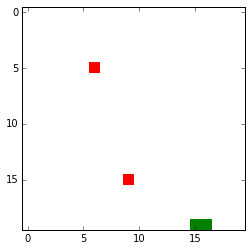

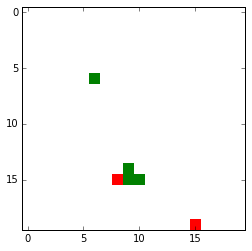

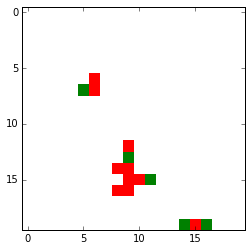

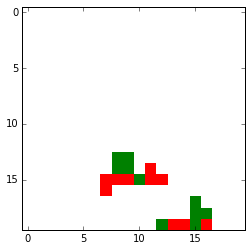

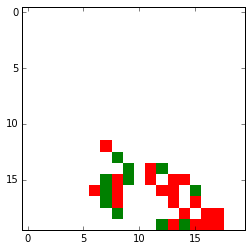

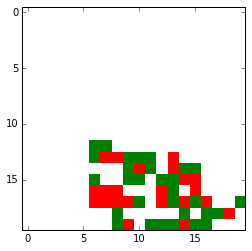

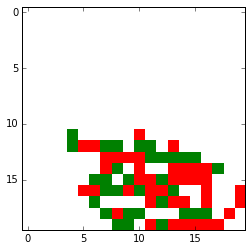

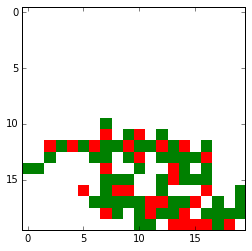

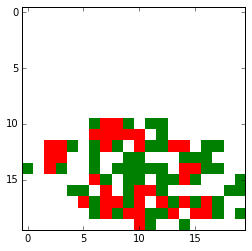

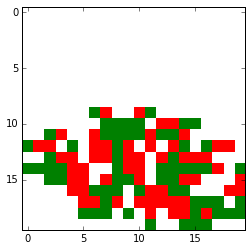

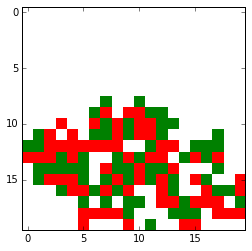

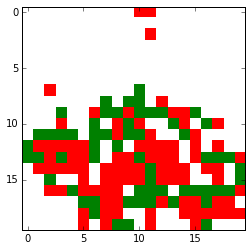

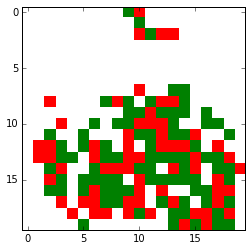

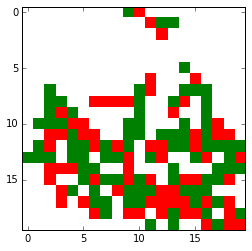

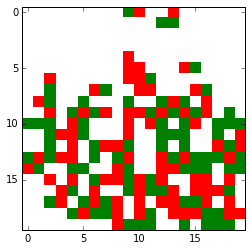

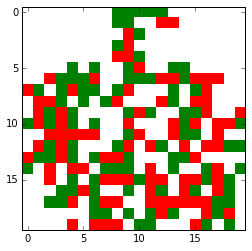

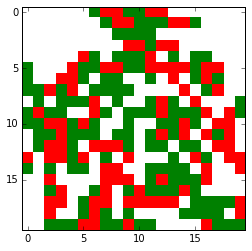

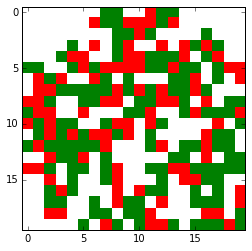

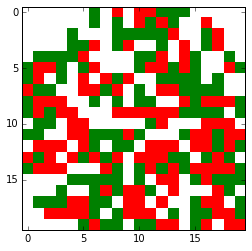

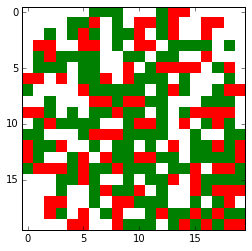

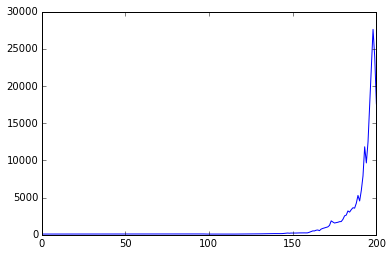

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
fig = plt.figure()

%matplotlib inline

initPrice = 100
model = CAStochastic(0.01, 20, 20, 0.0001, 0.05, 0.0485, initPrice)

steps = 200

prices = [initPrice]
for i in range(steps):
    model.doStep()
    prices = np.append(prices, model.getPrice())
    if i % 10 == 0:
        # declare variables
        N = 10 # size
        skip = 10
        saveVideo = False
        A = model.getGrid()

        cmap = mpl.colors.ListedColormap(['red','white','green'])
        bounds=[-1.1,-.1,.1,1.1]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        im = plt.imshow(A,interpolation='nearest',
                            cmap = cmap,norm=norm)

        plt.show()

plt.plot(prices)
plt.show()

# Reference
[1] Bartolozzi, M., & Thomas, A. W. (2004). Stochastic cellular automata model for stock market dynamics. Physical Review E, 69(4). http://doi.org/10.1103/PhysRevE.69.046112

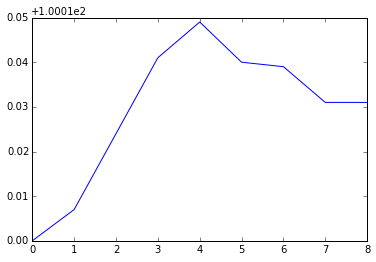

In [25]:
plt.plot(prices[1:10])